## A11535519 - Justin Laughlin
### MAE 290A: Homework 3 (11/21/17)
### Problem 2

In [1]:
# Import necessary packages & configure settings
import numpy as np
# contains more functions than np.linalg and always compiled with BLAS/LAPACK support so it could be faster
from scipy import linalg
import matplotlib.pyplot as plt
import timeit
import time

%matplotlib inline
fs_med = 16 # medium font size for plots
np.set_printoptions(precision=5)

<img src="hw3_2.png" style="width: 800px;"/>

<img src="hw2_3.png">

### Part 1: Numerically differentiating using splines

Typically, numerical derivatives are calculated using finite difference methods. However one can also use splines to interpolate between known data points; this results in a smooth and continuous function for $y(x)$ (see eq 3.3.3) which can then be differentiated to obtain another smooth and continuous function for $y'(x)$ (see eq 3.3.5). Equations 3.3.7 and 3.3.5 are used to construct a linear set of equations where the unknown vector consists of the values of $y''(x)$ at each point. Specifically, eq 3.3.7 is used for points $i=1,...,N-1$; while eq 3.3.5 is used for points $i=0,N$ (i.e. boundary conditions). Typically $y'(x)$ is prescribed at the boundaries which leaves only the $y''(x)$ terms as unknowns (as an example, see the bottom and top rows of the matrix equation in part 3). Since each point only depends on its adjacent points, the system will be tri-diagonal, making it very easy to solve!

Once the system has been solved, one can easily plug in values of $x$ and $y''(x)$ into eq 3.3.5 to obtain $y'(x)$; this procedure is demonstrated in the final plot at the bottom of this problem where $y'(x)$ calculated using splines is plotted vs $x$.

Note that $A$, $B$, $C$, and $D$ are all functions of $x$... this is important to realize when differentiating eq 3.3.3 to obtain eq 3.3.5.

### Part 2: Interpolating using splines

The process to interpolate between points using splines is almost exactly the same as differentiating as we explained in part 1. The only difference is instead of plugging values of $x$ and $y''(x)$ into eq 3.3.3 to obtain $y(x)$, we plug them into eq 3.3.5 to obtain $y'(x)$. To interpolate using splines one still must setup a linear system of equations using eq 3.3.7 and 3.3.5 (all of these processes are shown in detail in part 3!). Once $y''(x)$ has been solved for, we have all unknowns to solve for $y(x)$ in eq 3.3.3. See the first plot in part 3 which illustrates a spline fit of $y(x)$ vs $x$.

### Part 3: Applying differentiation using cubic splines

<img src="eq3_3_2.png" style="width: 700px;"/>
<img src="eq3_3_3.png" style="width: 700px;"/>
<img src="eq3_3_4.png" style="width: 700px;"/>
<img src="eq3_3_5.png" style="width: 700px;"/>
<img src="eq3_3_7.png" style="width: 700px;"/>

In [2]:
# Analytical values of x, y, and y'
xa = np.array([0,1,2])
ya = np.array([1,2,3])
ypa0 = 0  # y' analytical at x0
ypa2 = -6 # y'analytical at x2

# Function for eq 3.3.5 (derivative of spline)
def eval_dydx(xa,ya,ypp,j,x):
    # xa and ya are the known values of x and y
    # ypp is either calculated or provided (for the endpoints)
    # j is the index
    # x is the value we would like to evaluate the derivative at
    
    # A and B scale linearly between x_{j} and x_{j+1}. At x_{j}: A=1, B=0; at x_{j+1}: A=0, B=0
    xdiff = xa[j+1]-xa[j]
    ydiff = ya[j+1]-ya[j]
    A = (xa[j+1]-x)/xdiff
    B = 1-A

    dydx = (ydiff/xdiff) - (3*A**2-1)/6*xdiff*ypp[j] + (3*B**2-1)/6*(xdiff)*ypp[j+1]
    return dydx

We can find equations for $y''(0)$ and $y''(2)$ using eq 3.3.5 and taking advantage of the fact that $B=0$ at $x_0$ and $A=0$ at $x_2$

The matrix equation we must solve will be:

$$\begin{pmatrix}
-\frac16 (3(1)^2 - 1)(x_1 - x_0) & \frac16 (3(0)^2 - 1)(x_1 - x_0) & 0\\
(x_1 - x_0)/6 & (x_2-x_0)/3 & (x_2-x_1)/6\\
0 & -\frac16 (3(0)^2 - 1)(x_2 - x_1) & \frac16 (3(1)^2 - 1)(x_2 - x_1)
\end{pmatrix}
\begin{pmatrix}
y''_0 \\
y''_1 \\
y''_2 
\end{pmatrix} =
\begin{pmatrix}
0.0 - (y_1 - y_0)/(x_1 - x_0) \\
(y_2-y_1)/(x_2-x_1) - (y_1-y_0)/(x_1-x_0)\\
-6.0 - (y_2 - y_1)/(x_2 - x_1)
\end{pmatrix}$$

In general there will be $N$ unknowns and $N-2$ equations given by (3.3.7); the other two equations must come from (3.3.5) and/or boundary conditions. The form of eq 3.3.7 makes it clear that the matrix will be a tri-diagonal. Thus we will use a tridiagonal solver to obtain the solution.

In [3]:
c = np.array([0,-1/6*(xa[1]-xa[0]), (xa[2]-xa[1])/6]) # upper diag
b = np.array([-1/6*2*(xa[1]-xa[0]), (xa[2]-xa[0])/3, 1/6*2*(xa[2]-xa[1])]) # main diag
a = np.array([(xa[1]-xa[0])/6, 1/6*(xa[2]-xa[1]),0]) # lower diag

f = np.array([0.0 - (ya[1]-ya[0])/(xa[1]-xa[0]),
              (ya[2]-ya[1])/(xa[2]-xa[1]) - (ya[1]-ya[0])/(xa[1]-xa[0]),
              -6.0 - (ya[2]-ya[1])/(xa[2]-xa[1])]) # rhs vector 

abc = np.vstack((c,b,a)) # concatenate diagonals

ypp = linalg.solve_banded((1,1), abc,f) # solve tri-diagonal system

print('ypp =', ypp) # print results

ypp = [ -2.77556e-16   6.00000e+00  -2.40000e+01]


For curiosity, let's calculate and plot both $y(x)$ and $y'(x)$ as determined by our spline interpolation!

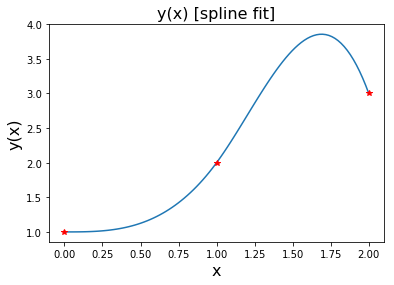

In [4]:
# Function for eq 3.3.5 (derivative of spline)
def eval_y(xa,ya,ypp,j,x):
    # xa and ya are the known values of x and y
    # ypp is either calculated or provided (for the endpoints)
    # j is the index
    # x is the value we would like to evaluate the derivative at
    
    # A and B scale linearly between x_{j} and x_{j+1}. At x_{j}: A=1, B=0; at x_{j+1}: A=0, B=0
    xdiff = xa[j+1]-xa[j]
    ydiff = ya[j+1]-ya[j]
    A = (xa[j+1]-x)/xdiff
    B = 1-A
    C = 1/6 * (A**3 - A)*xdiff**2
    D = 1/6 * (B**3 - B)*xdiff**2
    
    y = A*ya[j] + B*ya[j+1] + C*ypp[j] + D*ypp[j+1]
    return y

Nvec = 100
xvec = np.linspace(0,2,Nvec) # values to evaluate y(x) on
yvec = np.zeros(Nvec,) # initialize
ypvec = np.zeros(Nvec,)
for i in np.arange(Nvec):
    x = xvec[i]
    # index of spline
    j = np.int(np.floor(x))
    if x==2:
        j = 1
    # Calculate y(x) using spline fit
    yvec[i] = eval_y(xa,ya,ypp,j,x)
    ypvec[i] = eval_dydx(xa,ya,ypp,j,x)

# Plot y(x)
plt.plot(xvec,yvec)
plt.plot(xa,ya,'r*') # known values of y(x)
plt.xlabel('x',fontsize=fs_med)
plt.ylabel('y(x)',fontsize=fs_med)
plt.title('y(x) [spline fit]',fontsize=fs_med)

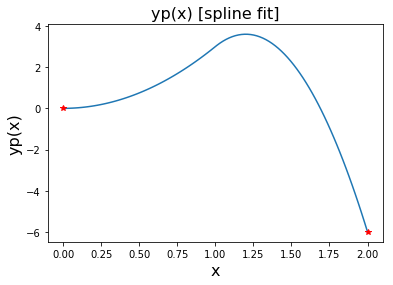

In [5]:
# Plot y'(x)
plt.plot(xvec,ypvec)
plt.plot([0,2],[ypa0,ypa2],'r*') # known values of y'(x)
plt.xlabel('x',fontsize=fs_med)
plt.ylabel('yp(x)',fontsize=fs_med)
plt.title('yp(x) [spline fit]',fontsize=fs_med)

The spline passes through all known points and the derivatives match up with our prescribed boundary conditions... Nice!

In [6]:
print('Derivative of spline at x=1 (yp_1): ', eval_dydx(xa,ya,ypp,0,1))

Derivative of spline at x=1 (yp_1):  3.0
